In [24]:
# Imports
import os, sys, math, glob
from datetime import datetime
import netCDF4 as nc
import numpy as np
from pymbar import timeseries, MBAR
import scipy.constants as cons
import mdtraj as md
#import dask.array as da
from copy import deepcopy
from datetime import datetime
import matplotlib.pyplot as plt
from typing import List
import seaborn as sns
from sklearn.decomposition import PCA
from pymbar.timeseries import detect_equilibration
# sys.path.append(os.path.dirname(os.path.realpath(__file__)))
from FultonMarketAnalysisUtils import *

fprint = lambda my_string: print(datetime.now().strftime("%m/%d/%Y %H:%M:%S") + ' // ' + str(my_string), flush=True)
get_kT = lambda temp: temp*cons.gas_constant
geometric_distribution = lambda min_val, max_val, n_vals: [min_val + (max_val - min_val) * (math.exp(float(i) / float(n_vals-1)) - 1.0) / (math.e - 1.0) for i in range(n_vals)]
rmsd = lambda a, b: np.sqrt(np.mean(np.sum((b-a)**2, axis=-1), axis=-1))


class FultonMarketAnalysis():
    """
    Analysis class for Replica Exchange Simulations written with Fulton Market

    methods:
        init: input_dir
    """
    def __init__(self, input_dir:str, pdb: str, skip: int=0, scheduling: str='Temperature', resids: List[int]=None, upper_limit: int=None):
        """
        get Numpy arrays, determine indices of interpolations, and set state_inds
        """
        
        # Find directores
        if input_dir.endswith('/'):
            input_dir = input_dir[:-1]
        self.input_dir = input_dir
        self.stor_dir = os.path.join(input_dir, 'saved_variables')
        assert os.path.isdir(self.stor_dir), self.stor_dir
        fprint(f"Found storage directory at {self.stor_dir}")
        self.storage_dirs = sorted(glob.glob(self.stor_dir + '/*'), key=lambda x: int(x.split('/')[-1]))
        self.pdb = pdb 
        self.top = md.load_pdb(self.pdb).topology
        if resids is not None:
            self.resids = [[self.top.residue(i).resSeq for i in range(self.top.n_residues)].index(resid) for resid in resids] # convert to mdtraj resids
        
        # Load saved variables
        self.temperatures_list = [np.round(np.load(os.path.join(storage_dir, 'temperatures.npy'), mmap_mode='r'), decimals=2) for storage_dir in self.storage_dirs]
        self.temperatures = self.temperatures_list[-1]
        fprint(f"Shapes of temperature arrays: {[(i, temp.shape) for i, temp in enumerate(self.temperatures_list)]}")
        self.state_inds = [np.load(os.path.join(storage_dir, 'states.npy'), mmap_mode='r')[skip:] for storage_dir in self.storage_dirs]
        self.unshaped_energies = [np.load(os.path.join(storage_dir, 'energies.npy'), mmap_mode='r')[skip:] for storage_dir in self.storage_dirs]
        self.unshaped_positions = [np.load(os.path.join(storage_dir, 'positions.npy'), mmap_mode='r')[skip:] for storage_dir in self.storage_dirs]
        self.unshaped_box_vectors = [np.load(os.path.join(storage_dir, 'box_vectors.npy'), mmap_mode='r')[skip:] for storage_dir in self.storage_dirs]
            
        # Reshape lists 
        self.energies = self._reshape_list(self.unshaped_energies)

        # Compute positions/box_vectors map 
        self._get_postions_map()
        self.skip = skip        

        # Determine if interpolation occured and resample to fill in missing states
        self.scheduling = scheduling
        self._backfill()

        # Apply upper limit, if specified
        if upper_limit is not None:
            self.energies = self.energies[:upper_limit+1]
            self.map = self.map[:upper_limit+1]
            self.upper_limit = upper_limit
        
        fprint(f'Shape of final energies determined to be: {self.energies.shape}')


        
        
    def get_state_energies(self, state_index: int=0):
        """
        get energies of each replicate in its own state (iters, state, state) -> (iters, state)
        Optionally reduce energies based on temperatures, and concatenate the list of arrays to a single array
        """
        
        state_energies = self.energies[:,state_index, state_index]
        
        return state_energies
    
    
    def get_average_energy(self, plot: bool=False, figsize: tuple=(6,6)):
        """
        """
        
        # Determine equilibration
        self._determine_equilibration()

        # Get average energies
        state_energies = np.empty((self.energies.shape[0], self.energies.shape[1]))
        for state in range(self.energies.shape[1]):
            state_energies[:,state] = self.energies[:,state,state]
        self.average_energies = state_energies.mean(axis=1)
        
        # Plot if specified:
        if plot:
            fig, ax = plt.subplots(figsize=figsize)
            ax.plot(range(self.average_energies.shape[0]), self.average_energies, color='k')
            ax.vlines(self.t0, self.average_energies.min(), self.average_energies.max(), color='r', label='equilibration')
            ax.legend(bbox_to_anchor=(1,1))
            ax.set_title('Mean energy')
            ax.set_ylabel('Energy (kJ/mol)')
            ax.set_xlabel('Iterations')
            fig.tight_layout()
            plt.show
            return self.average_energies[self.t0:], fig, ax
        else:
            return self.average_energies[self.t0:]
        
        
    def plot_energy_distributions(self, figsize: tuple=(8,4), post_equil: bool=False):  

        if post_equil:
            if not hasattr(self, 't0'):
                self._determine_equilibration()
            state_energies = np.array([self.get_state_energies(state_index=state_no)[self.t0:] for state_no in range(self.energies.shape[1])]).T
        else:
            state_energies = np.array([self.get_state_energies(state_index=state_no) for state_no in range(self.energies.shape[1])]).T

        
        fig, ax = plt.subplots(figsize=figsize)
        
        
        sns.kdeplot(state_energies, ax=ax, legend=False)
        ax.set_xlabel('Energy (kJ/mol)')
        fig.tight_layout()
        plt.show()
        
        return fig, ax 
    
    
    
    def importance_resampling(self, n_samples:int=1000, equilibration_method: str='PCA', specify_state:int=0, upper_lim: int=None, replace: bool=True):
        """
        """           
        self.equilibration_method = equilibration_method
        
        #Ensure equilibration has been detected
        if not hasattr(self, 't0'):
            self._determine_equilibration()
        
        # Create map to match shape of weights
  
        # Get MBAR weights
        if self.equilibration_method == 'energy':
            u_kln = self.energies[self.t0:][self.uncorrelated_indices].T
            N_k = [len(self.uncorrelated_indices) for i in range(self.energies.shape[1])]
            self.flat_inds = np.array([[state, ind] for ind in self.uncorrelated_indices for state in range(self.energies.shape[1])])

        else:
            self.flat_inds = np.array([[state, ind] for ind in range(self.t0, self.energies.shape[0]) for state in range(self.energies.shape[1])])
            u_kln = self.energies[self.t0:].T
            N_k = [self.energies[self.t0:].shape[0] for i in range(self.energies.shape[1])]
        self.resampled_inds, self.weights, self.resampled_weights = resample_with_MBAR(objs=[self.flat_inds], u_kln=u_kln, N_k=N_k, size=n_samples, return_inds=False, return_weights=True, return_resampled_weights=True, specify_state=0, replace=replace)
        
        

    def plot_weights(self, state_no: int=0, figsize: tuple=(4,4)):
        # Reshape weights
        self.weights = self.weights.copy().reshape(self.temperatures.shape[0], self.energies.shape[0] - self.t0, self.temperatures.shape[0])[:,:,state_no].T
        
        # Get sum of weights by state
        sum_weights = self.weights.sum(axis=0)
        
        # Plot
        fig, ax = plt.subplots(figsize=figsize)
        ax.bar(range(sum_weights.shape[0]), sum_weights, color='k')
        ax.set_ylabel('MBAR Weights')
        ax.set_xlabel('Temperature (K)')
        ax.set_xticks(range(self.temperatures.shape[0])[::10], self.temperatures[::10], rotation=90)
        fig.tight_layout()
        plt.show()
        
        return fig, ax
    
    
    
    def write_resampled_traj(self, pdb_out: str, dcd_out: str, weights_out: str=None, return_traj: bool=False):
        
        # Make sure resampling has already occured
        if not hasattr(self, 'resampled_inds'):
            self.importance_resampling()
            
        # Load pos, box_vec
        if not hasattr(self, 'positions'):
            self._load_positions_box_vecs()
        
        # Create mdtraj obj
        traj = md.load_pdb(self.pdb)
        
        # Use the map to find the resampled configurations
        pos = np.empty((len(self.resampled_inds), self.positions[0].shape[2], 3))
        box_vec = np.empty((len(self.resampled_inds), 3, 3))
        for i, (state, iter) in enumerate(self.resampled_inds):

            # Use map
            sim_no, sim_iter, sim_rep_ind = self.map[iter, state].astype(int)
            
            pos[i] = np.array(self.positions[sim_no][sim_iter][sim_rep_ind])
            box_vec[i] = np.array(self.box_vectors[sim_no][sim_iter][sim_rep_ind])
        
        # Apply pos, box_vec to mdtraj obj
        traj.xyz = pos.copy()
        traj.unitcell_vectors = box_vec.copy()
        traj.save_dcd(dcd_out)
        
        # Correct periodic issues
        traj = md.load(dcd_out, top=self.pdb)
        prot_sele = self.top.select('protein')
        traj = traj.superpose(traj, atom_indices=prot_sele, ref_atom_indices=prot_sele)
        traj.image_molecules()
        traj[0].save_pdb(pdb_out)
        traj.save_dcd(dcd_out)
        fprint(f'{traj.n_frames} frames written to {pdb_out}, {dcd_out}')

        # Save weights, if specified
        if weights_out is not None:
            np.save(weights_out, self.resampled_weights)
            fprint(f'{traj.n_frames} mbar weights written to {weights_out}')

        
        if return_traj:
            return traj

       
    

    def state_trajectory(self, state_no=0, stride: int=1):
        """    
        State_no is the thermodynamics state to retrieve
        If pdb file is provided (top_file), then an MdTraj trajectory will be returned
        If top_file is None - the numpy array of positions will be returned
        """
        if not (hasattr(self, 'positions') or hasattr(self, 'box_vectors')):
            self._load_positions_box_vecs()
            
        # Create mdtraj obj
        traj = md.load_pdb(self.pdb)

        # Use the map to find the resampled configurations
        inds = np.arange(0, self.energies.shape[0], stride)
        pos = np.empty((len(inds), self.positions[0].shape[2], 3))
        box_vec = np.empty((len(inds), 3, 3))
        for i, ind in enumerate(inds):
            
            # Use map
            sim_no, sim_iter, sim_rep_ind = self.map[ind, state_no].astype(int)
            pos[i] = np.array(self.positions[sim_no][sim_iter][sim_rep_ind])
            box_vec[i] = np.array(self.box_vectors[sim_no][sim_iter][sim_rep_ind])
        
        # Apply pos, box_vec to mdtraj obj
        traj.xyz = pos.copy()
        traj.unitcell_vectors = box_vec.copy()
        temp = f'temp_{self.pdb.split("/")[-1].split(".")[0]}_{np.random.randint(9999)}'
        traj.save_dcd(f'{temp}.dcd')
        
        # Correct periodic issues
        traj = md.load(f'{temp}.dcd', top=self.pdb)
        os.remove(f'{temp}.dcd')
        traj.image_molecules()
        
        # Align 
        prot_sel = self.top.select('protein and name CA')
        traj = traj.superpose(traj, frame=0, atom_indices=prot_sel, ref_atom_indices=prot_sel)
        

        return traj
    
    
    
    def _reshape_list(self, unshaped_list: List):
        """
        Return a list of reshaped arrays. 
        
        Parameters:
        ------------
            unshaped_list (List):
                List of numpy arrays that need the 1st axis reshaped 
        """
        reshaped_array = []
        for i in range(len(self.storage_dirs)):
            reshaped_array.append(self._reshape_array(unshaped_arr=unshaped_list[i], state_arr=self.state_inds[i]))
        return reshaped_array      

    
    
    def _reshape_array(self, unshaped_arr: np.array, state_arr: np.array):
        """
        Return a reshaped array. 

        Parameters:
        ------------
            unshaped_arr (np.array):
                Numpy arrays that need the 1st axis reshaped.

            state_arr (np.array)
                Numpy array with the state indices for each replicate
        """        
        # Reshape 1st axis
        reshaped_arr = np.empty(unshaped_arr.shape)
        for state in range(unshaped_arr.shape[1]):
            for iter_num in range(unshaped_arr.shape[0]):
                reshaped_arr[iter_num, state, :] = unshaped_arr[iter_num, np.where(state_arr[iter_num] == state)[0], :]
        
        return reshaped_arr
    
    
    
    def _get_postions_map(self):
        """
        Dimensions of map:  Dimensions are (sim_no, iteration, state) >>> corresponding[sim_no, state, iter]. EXAMPLE: self.map[1,0] could return [0, 1, 2] which means the correct positions for the 1st interation at the 0th state of the reshaped energies matrix can be cound at the the 2nd iteration of the 1st replicate of the 0th simulation.
        """
        
        
        # Make maps
        self.map = []
        for sim_no, sim_state_inds in enumerate(self.state_inds):
    
            # Build map for simulation
            sim_map = np.empty((self.energies[sim_no].shape[0], self.energies[sim_no].shape[1], 3), dtype=int)
    
            # Iterate through simulation iters, states to build map
            for sim_iter in range(sim_map.shape[0]):
                for sim_state in range(sim_map.shape[1]):
                    sim_map[sim_iter, sim_state, :] = np.array([sim_no, sim_iter, np.where(sim_state_inds[sim_iter] == sim_state)[0][0]], dtype=int)
    
            # Add sim_map
            self.map.append(sim_map.astype(int))


    def _determine_interpolation_inds(self):
        """
        determine the indices (with respect to the last simulation) which are missing from other simulations
        """
        # Set interpolation attribute
        if self.scheduling == 'Spring Centers' and hasattr(self, 'spring_centers_list'):
            interpolation_list = [centers[:,0] for centers in self.spring_centers_list]
            final_set = self.spring_centers[:,0]
        else:
            interpolation_list = self.temperatures_list
            final_set = self.temperatures
            
        # Iterate through temperatures
        self.interpolation_inds = []
        for i, set_i in enumerate(interpolation_list):
            missing_sim_inds = []
            for i, s in enumerate(final_set):
                if s not in set_i:
                    missing_sim_inds.append(i)
        
            # Assert that interpolation made sense
            assert len(missing_sim_inds) + len(set_i) == len(final_set), f'{len(missing_sim_inds)}, {len(set_i)}, {len(final_set)}'
            self.interpolation_inds.append(missing_sim_inds)



    def _backfill(self):
        """
        
        """
        # Determine interpolation inds
        self._determine_interpolation_inds()
        fprint(f'Detected interpolations at: {self.interpolation_inds}')

        # Determine which simulations to resample from
        filled_sims = [True if not self.interpolation_inds[i] else False for i in range(len(self.interpolation_inds))]
        filled_sim_inds = [i for i in range(len(filled_sims)) if filled_sims[i] == True]

        #Make an interpolation map
        interpolation_map = [np.arange(self.temperatures.shape[0]) for i in range(len(self.temperatures))] # in shape (state, state) >>> state_ind
        for i, interpolation_ind_set in enumerate(self.interpolation_inds):
            for ind in interpolation_ind_set:
                interpolation_map[i] = interpolation_map[i][interpolation_map[i] != ind]

        # Iterate throught simulations to backfill energies
        backfilled_energies = []
        backfilled_potentials = []
        backfilled_map = []
        for sim_no, sim_interpolate_inds in enumerate(self.interpolation_inds):
            
            #Create an array for this simulations energies, in the final simulation's shape on axis 1, 2
            sim_energies = np.zeros((self.energies[sim_no].shape[0], self.temperatures.shape[0], self.temperatures.shape[0]))
            sim_reduced_potentials = np.zeros((self.energies[sim_no].shape[0], self.temperatures.shape[0], self.temperatures.shape[0]))
            sim_map = np.zeros((self.map[sim_no].shape[0], self.temperatures.shape[0], 3))

            #Fill this array with the values that exist
            for i, ind in enumerate(interpolation_map[sim_no]):
                sim_energies[:, ind, interpolation_map[sim_no]] = self.energies[sim_no][:, i, :]
                sim_reduced_potentials[:, ind, interpolation_map[sim_no]] = self.energies[sim_no][:, i, :]
                sim_map[:,ind] = self.map[sim_no][:,i]

            #Fill in rows and columns 
            for state_no in sim_interpolate_inds:

                # Get state-specific objects to resample from
                filled_reduced_potentials = np.concatenate([self.energies[sim_no] for sim_no in filled_sim_inds])
                filled_energies = np.concatenate([self.energies[sim_no] for sim_no in filled_sim_inds])
                filled_map = np.concatenate([self.map[sim_no] for sim_no in filled_sim_inds])
                
                state_reduced_potentials = filled_reduced_potentials[:, state_no]
                state_energies = filled_energies[:, state_no]
                state_map = filled_map[:, state_no]

                N_k = np.array([state_reduced_potentials.shape[0]])

                # Resample
                res_potentials, res_energies, res_mappings, res_inds = resample_with_MBAR(objs=[state_reduced_potentials, state_energies, state_map], u_kln=np.array([state_reduced_potentials[:,state_no]]), N_k=N_k, reshape_weights=state_reduced_potentials.shape[0], return_inds=True, size=len(sim_energies))


                # Assign resampled configurations to empty rows/cols
                sim_energies[:, state_no] = res_energies.copy()
                sim_reduced_potentials[:, state_no] = res_potentials.copy()
                sim_map[:, state_no] = res_mappings.copy()

                sim_energies[:, :, state_no] = [filled_energies[resampled_ind, :, state_no] for resampled_ind in res_inds]
                sim_reduced_potentials[:, :, state_no] = [filled_reduced_potentials[resampled_ind, :, state_no] for resampled_ind in res_inds]


            backfilled_energies.append(sim_energies)
            backfilled_potentials.append(sim_reduced_potentials)
            backfilled_map.append(sim_map)

        # Concatenate
        self.energies = np.concatenate(backfilled_energies, axis=0)
        self.energies = np.concatenate(backfilled_potentials, axis=0)
        self.map = np.concatenate(backfilled_map, axis=0).astype(int)
        self.n_frames = self.energies.shape[0]
    
    

    def _determine_equilibration(self):
        """
        Automated equilibration detection
        suggests an equilibration index (with respect to the whole simulation) by detecting equilibration for the average energies
        starting from each of the first 50 frames
        returns the likely best index of equilibration
        """

        
        # Compute average energies
        if self.equilibration_method == 'energy':
            
            self.average_energies = np.zeros((self.energies.shape[0], self.energies.shape[1]))
            for state_no in range(self.energies.shape[1]):
                self.average_energies[:,state_no] = self.get_state_energies(state_index=state_no)
            self.average_energies = self.average_energies.mean(axis=1)

            self.t0, self.g, Neff_max = timeseries.detect_equilibration(self.average_energies) # compute indices of uncorrelated timeseries
            A_t_equil = self.average_energies[self.t0:]
            indices = timeseries.subsample_correlated_data(A_t_equil, g=self.g)
            A_n = A_t_equil[indices]
            self.uncorrelated_indices = indices
            
         
        elif self.equilibration_method == 'PCA':    
            # PCA
            pca, self.reduced_cartesian, self.explained_variance, self.n_components = self.get_PCA(explained_variance_threshold=0.9)
            
            # Iterate through PCs to detect equilibration
            equil_times = np.empty(self.n_components)
            for pc in range(self.n_components):
                equil_times[pc] = detect_PC_equil(pc, self.reduced_cartesian)


            # Save equilibration/uncorrelated inds to new variables
            self.pca_weights = pca.explained_variance_ratio_[:self.n_components]
            self.t0 = np.sum(equil_times  * (self.pca_weights / self.pca_weights.sum())).astype(int)
         
        elif self.equilibration_method == 'None':
            self.t0 = 0
          
        else:
            print('equilibration_method must be either PCA or energy (or None if youre zesty)')

        fprint(f'Equilibration detected at {np.round(self.t0 / 10, 3)} ns with method: {self.equilibration_method}')

    

    def get_PCA(self, state_no: int=0, stride: int=10, n_components: int=2, explained_variance_threshold: float=None):
        """
        """
        # Get state trajectory
        traj = self.state_trajectory(state_no, stride)
        if hasattr(self, 'upper_limit'):
            traj = traj[:self.upper_limit+1]

        # Get protein or resids of interest
        if self.resids is not None:
            sele = traj.topology.select(f'resid {" ".join([str(resid) for resid in self.resids])}')
        else:
            sele = traj.topology.select('protein')
        traj = traj.atom_slice(sele)
    
        # PCA
        pca = PCA()
        reduced_cartesian = pca.fit_transform(traj.xyz.reshape(traj.n_frames, traj.n_atoms * 3))
        explained_variance = np.array([np.sum(pca.explained_variance_ratio_[:i+1]) for i in range(pca.n_components_)])

        if explained_variance_threshold is not None:
            n_components = int(np.where(explained_variance >= explained_variance_threshold)[0][0])

        return pca, reduced_cartesian[:,:n_components], explained_variance[:n_components], n_components

    
    
    def _load_positions_box_vecs(self):
        
        # Load
        self.positions = []
        self.box_vectors = []
        for sim_no, storage_dir in enumerate(self.storage_dirs):
            self.positions.append(np.load(os.path.join(storage_dir, 'positions.npy'), mmap_mode='r')[self.skip:])
            self.box_vectors.append(np.load(os.path.join(storage_dir, 'box_vectors.npy'), mmap_mode='r')[self.skip:]) 


def calculate_weighted_projection(rc, nframes, n_components, weights):
    reduced_cartesian_to_calc = rc[:nframes]
    component_coords = dict()
    for pc in range(n_components):
        # compute the weighted reduced cartesian values after equilibration
        component_coords[pc] = reduced_cartesian_to_calc[:, pc] * weights[pc] 

    weighted_aggregated_cartesian = []
    for i in range(len(component_coords[0])): # Iterate over each sample
        temp_sum = sum(component_coords[pc][i] for pc in range(n_components))
        weighted_aggregated_cartesian.append(temp_sum)
    weighted_aggregated_cartesian = np.array(weighted_aggregated_cartesian)
    return weighted_aggregated_cartesian


c11guano_6
01/08/2025 22:38:46 // Found storage directory at /ocean/projects/bio240035p/dcooper/MOR/replica_exchange/c11guano_6/saved_variables
01/08/2025 22:38:48 // Shapes of temperature arrays: [(0, (116,)), (1, (116,)), (2, (116,)), (3, (116,)), (4, (116,)), (5, (116,)), (6, (118,)), (7, (119,)), (8, (119,)), (9, (119,)), (10, (119,)), (11, (119,)), (12, (119,)), (13, (119,)), (14, (120,)), (15, (120,)), (16, (120,)), (17, (120,)), (18, (120,)), (19, (120,)), (20, (120,)), (21, (120,)), (22, (122,)), (23, (122,)), (24, (122,)), (25, (122,)), (26, (122,)), (27, (122,)), (28, (122,)), (29, (122,)), (30, (122,)), (31, (122,)), (32, (122,)), (33, (123,)), (34, (123,)), (35, (123,)), (36, (123,)), (37, (123,))]
01/08/2025 22:39:23 // Detected interpolations at: [[60, 65, 72, 74, 88, 92, 99], [60, 65, 72, 74, 88, 92, 99], [60, 65, 72, 74, 88, 92, 99], [60, 65, 72, 74, 88, 92, 99], [60, 65, 72, 74, 88, 92, 99], [60, 65, 72, 74, 88, 92, 99], [65, 72, 88, 92, 99], [72, 88, 92, 99], [72, 88,

/var/tmp/ipykernel_42557/2721382433.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean_weighted_rc_err[i] = np.std(domain_weighed_rc) / np.sqrt(domain_weighed_rc.shape)


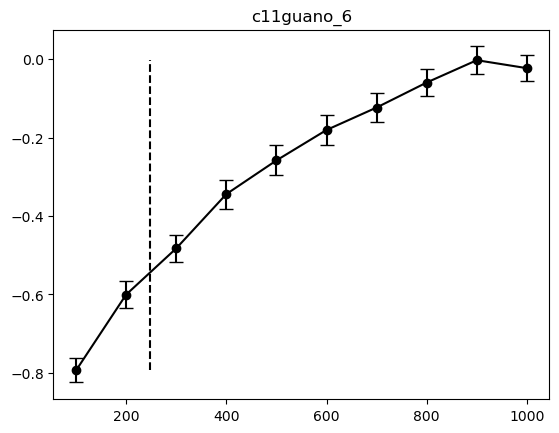

8efb_6
01/08/2025 22:40:11 // Found storage directory at /ocean/projects/bio240035p/dcooper/MOR/replica_exchange/8efb_6/saved_variables
01/08/2025 22:40:14 // Shapes of temperature arrays: [(0, (122,)), (1, (122,)), (2, (123,)), (3, (123,)), (4, (123,)), (5, (123,)), (6, (123,)), (7, (123,)), (8, (123,)), (9, (123,)), (10, (123,)), (11, (123,)), (12, (124,)), (13, (125,)), (14, (125,)), (15, (125,)), (16, (125,)), (17, (125,)), (18, (125,)), (19, (125,)), (20, (125,)), (21, (125,)), (22, (125,)), (23, (125,)), (24, (125,)), (25, (125,)), (26, (125,)), (27, (125,)), (28, (125,)), (29, (125,)), (30, (125,)), (31, (125,)), (32, (126,)), (33, (126,)), (34, (126,)), (35, (126,)), (36, (126,)), (37, (126,))]
01/08/2025 22:41:38 // Detected interpolations at: [[59, 78, 92, 114], [59, 78, 92, 114], [59, 92, 114], [59, 92, 114], [59, 92, 114], [59, 92, 114], [59, 92, 114], [59, 92, 114], [59, 92, 114], [59, 92, 114], [59, 92, 114], [59, 92, 114], [59, 114], [114], [114], [114], [114], [114], [1

/var/tmp/ipykernel_42557/2721382433.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean_weighted_rc_err[i] = np.std(domain_weighed_rc) / np.sqrt(domain_weighed_rc.shape)


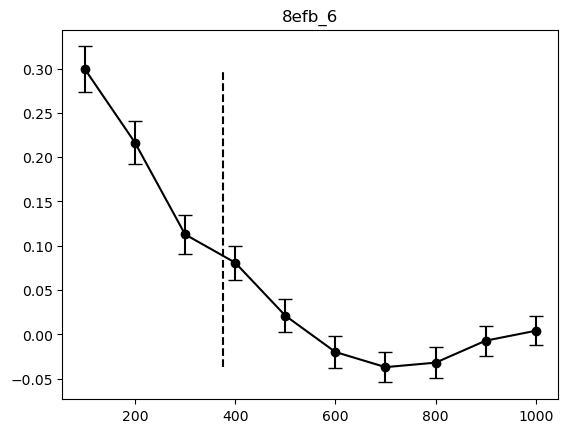

7u2l_6
01/08/2025 22:44:21 // Found storage directory at /ocean/projects/bio240035p/dcooper/MOR/replica_exchange/7u2l_6/saved_variables
01/08/2025 22:44:23 // Shapes of temperature arrays: [(0, (116,)), (1, (116,)), (2, (116,)), (3, (116,)), (4, (116,)), (5, (116,)), (6, (116,)), (7, (116,)), (8, (116,)), (9, (116,)), (10, (117,)), (11, (118,)), (12, (120,)), (13, (121,)), (14, (122,)), (15, (122,)), (16, (122,)), (17, (122,)), (18, (122,)), (19, (122,)), (20, (122,)), (21, (122,)), (22, (122,)), (23, (123,)), (24, (123,)), (25, (123,)), (26, (124,)), (27, (124,)), (28, (124,)), (29, (124,)), (30, (124,)), (31, (124,)), (32, (124,)), (33, (124,))]
01/08/2025 22:45:39 // Detected interpolations at: [[64, 67, 74, 80, 83, 88, 98, 113], [64, 67, 74, 80, 83, 88, 98, 113], [64, 67, 74, 80, 83, 88, 98, 113], [64, 67, 74, 80, 83, 88, 98, 113], [64, 67, 74, 80, 83, 88, 98, 113], [64, 67, 74, 80, 83, 88, 98, 113], [64, 67, 74, 80, 83, 88, 98, 113], [64, 67, 74, 80, 83, 88, 98, 113], [64, 67, 74,

/var/tmp/ipykernel_42557/2721382433.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean_weighted_rc_err[i] = np.std(domain_weighed_rc) / np.sqrt(domain_weighed_rc.shape)


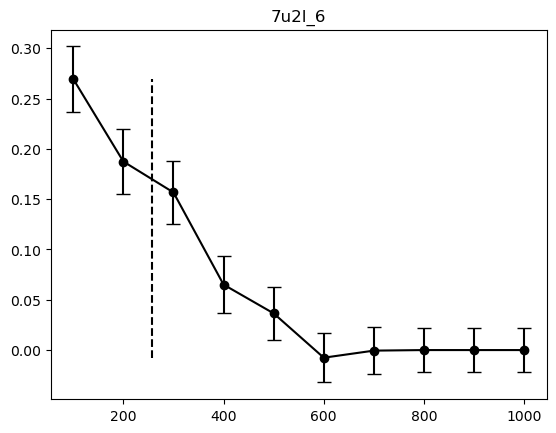

c7guano_6
01/08/2025 22:48:50 // Found storage directory at /ocean/projects/bio240035p/dcooper/MOR/replica_exchange/c7guano_6/saved_variables
01/08/2025 22:48:53 // Shapes of temperature arrays: [(0, (116,)), (1, (116,)), (2, (117,)), (3, (117,)), (4, (117,)), (5, (117,)), (6, (117,)), (7, (117,)), (8, (117,)), (9, (118,)), (10, (118,)), (11, (118,)), (12, (118,)), (13, (118,)), (14, (118,)), (15, (118,)), (16, (118,)), (17, (118,)), (18, (119,)), (19, (120,)), (20, (120,)), (21, (120,)), (22, (120,)), (23, (122,)), (24, (123,)), (25, (123,)), (26, (123,)), (27, (123,)), (28, (123,)), (29, (123,)), (30, (125,)), (31, (125,)), (32, (125,)), (33, (125,))]
01/08/2025 22:50:08 // Detected interpolations at: [[53, 59, 63, 66, 77, 80, 82, 84, 111], [53, 59, 63, 66, 77, 80, 82, 84, 111], [53, 59, 63, 66, 77, 80, 82, 111], [53, 59, 63, 66, 77, 80, 82, 111], [53, 59, 63, 66, 77, 80, 82, 111], [53, 59, 63, 66, 77, 80, 82, 111], [53, 59, 63, 66, 77, 80, 82, 111], [53, 59, 63, 66, 77, 80, 82, 111]

/var/tmp/ipykernel_42557/2721382433.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean_weighted_rc_err[i] = np.std(domain_weighed_rc) / np.sqrt(domain_weighed_rc.shape)


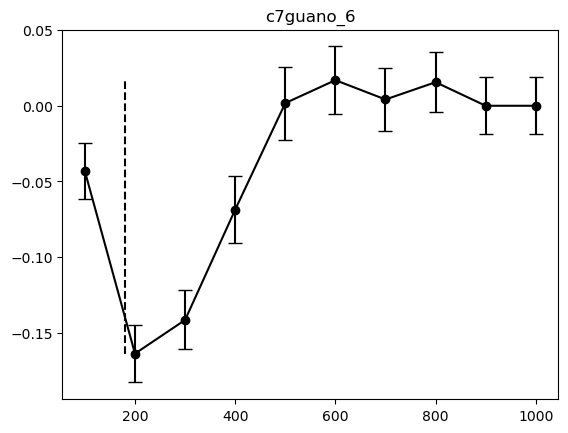

c9guano_6
01/08/2025 22:52:32 // Found storage directory at /ocean/projects/bio240035p/dcooper/MOR/replica_exchange/c9guano_6/saved_variables
01/08/2025 22:52:35 // Shapes of temperature arrays: [(0, (117,)), (1, (117,)), (2, (118,)), (3, (118,)), (4, (119,)), (5, (119,)), (6, (119,)), (7, (119,)), (8, (119,)), (9, (119,)), (10, (120,)), (11, (120,)), (12, (120,)), (13, (120,)), (14, (120,)), (15, (120,)), (16, (121,)), (17, (121,)), (18, (121,)), (19, (121,)), (20, (121,)), (21, (121,)), (22, (121,)), (23, (122,)), (24, (122,)), (25, (122,)), (26, (122,)), (27, (122,)), (28, (123,)), (29, (124,)), (30, (124,)), (31, (124,)), (32, (124,)), (33, (124,))]
01/08/2025 22:53:43 // Detected interpolations at: [[56, 70, 73, 91, 98, 100, 114], [56, 70, 73, 91, 98, 100, 114], [56, 70, 73, 91, 98, 100], [56, 70, 73, 91, 98, 100], [56, 73, 91, 98, 100], [56, 73, 91, 98, 100], [56, 73, 91, 98, 100], [56, 73, 91, 98, 100], [56, 73, 91, 98, 100], [56, 73, 91, 98, 100], [56, 91, 98, 100], [56, 91, 98

/var/tmp/ipykernel_42557/2721382433.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean_weighted_rc_err[i] = np.std(domain_weighed_rc) / np.sqrt(domain_weighed_rc.shape)


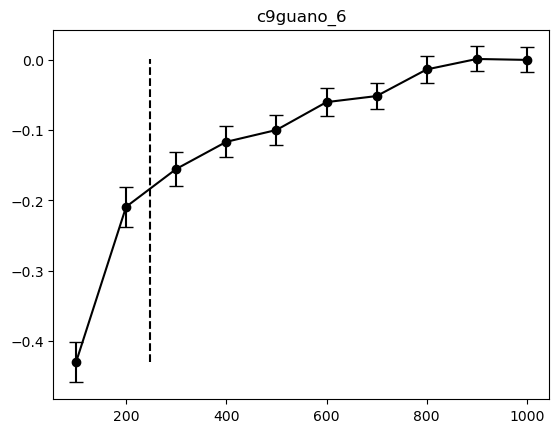

In [74]:
# Input 
repexch_dir = '/ocean/projects/bio240035p/dcooper/MOR/replica_exchange/'
pdb_dir = '/ocean/projects/bio240035p/dcooper/MOR/final/resampled/analogues/convergance/all_frames/10000/pdb'
resids = np.load('MOR_resids.npy')

for drug in os.listdir(repexch_dir):

    print(drug)
    analysis = FultonMarketAnalysis(input_dir=os.path.join(repexch_dir, drug), pdb=os.path.join(pdb_dir, f'{drug.split("_")[0]}_9.pdb'), skip=10, resids=resids)

    analysis.equilibration_method='PCA'
    analysis._determine_equilibration()


    domains = np.arange(1000, 11000, 1000)
    mean_weighted_rc = np.empty(len(domains))
    mean_weighted_rc_err = np.empty(len(domains))
    for i, domain in enumerate(domains):
        n_frames = int(domain / 10)
        domain_weighed_rc = calculate_weighted_projection(analysis.reduced_cartesian, n_frames, analysis.n_components, analysis.pca_weights)
        mean_weighted_rc[i] = np.mean(domain_weighed_rc)
        mean_weighted_rc_err[i] = np.std(domain_weighed_rc) / np.sqrt(domain_weighed_rc.shape)
    
    plt.title(drug)
    plt.errorbar(domains/10, mean_weighted_rc, yerr=mean_weighted_rc_err, fmt='-o', color='black', capsize=5)
    plt.vlines(analysis.t0/10, mean_weighted_rc.min(), mean_weighted_rc.max(), color='k', ls='dashed')
    plt.show()

    np.save(f'./PCA_convergence/{drug}_mean_weighted_rc.npy', mean_weighted_rc)